In [140]:
from src.wrds_pull import fetch_taq_data
from src.strategy import OBIVWAPStrategy, MeanReversionStrategy
from src.plot import plot_account_balance
from src.performance import evaluate_strategy_performance
import random
import polars as pl
import gc
import matplotlib.pyplot as plt


EX_FILTER = "'Z'"
# EX_FILTER = exchanges = "'Q', 'N', 'T', 'P', 'Z', 'B', 'C', 'X', 'Y', 'A', 'M', 'D', 'I', 'J', 'K', 'L', 'V', 'W', 'U', 'S', 'F', 'G', 'H', 'O', 'R'"
QU_COND_FILTER = "'R'"
START_DATE = '2023-05-10'
END_DATE = '2023-05-10'
START_TIME = (9, 55)
END_TIME = (15, 36)
VWAP_WINDOW = 500
OBI_THRESHOLD = 0
SIZE_THRESHOLD = 0
VWAP_THRESHOLD = 0

In [14]:
# Choose a batch of tickers (example: first 2 from your filtered list)
with open("data/positive_return_tickers_v1.txt") as f:
    all_filtered = [line.strip() for line in f if line.strip()]

batch = random.sample(all_filtered, 2)
# batch = all_filtered[0:5] 
print("Batch tickers:", batch)

Batch tickers: ['C', 'OXY']


In [ ]:
# Fetch TAQ data for this batch
df = fetch_taq_data(
    tickers=batch,
    exchanges=EX_FILTER,
    quote_conds=QU_COND_FILTER,
    start_date=START_DATE,
    end_date=END_DATE,
    wrds_username='changjulian17'
)

Loading library list...
Done


date,time_m,time_m_nano,ex,sym_root,sym_suffix,bid,bidsiz,ask,asksiz,qu_cond,qu_seqnum,natbbo_ind,qu_cancel,qu_source,rpi,ssr,luld_bbo_indicator,finra_bbo_ind,finra_adf_mpid,finra_adf_time,finra_adf_time_nano,finra_adf_mpq_ind,finra_adf_mquo_ind,sip_message_id,natl_bbo_luld,part_time,part_time_nano,secstat_ind,Timestamp
str,str,i64,str,str,str,f64,i64,f64,i64,str,i64,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,datetime[ns]
"""2023-05-10""","""09:30:00.021311""",744,"""Z""","""C""",null,46.76,3,47.33,3,"""R""",186480,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,null,"""09:30:00.021069""",0,null,2023-05-10 09:30:00.021311744
"""2023-05-10""","""09:30:00.076542""",976,"""Z""","""C""",null,46.76,3,47.33,3,"""R""",186947,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,null,"""09:30:00.076302""",0,null,2023-05-10 09:30:00.076542976
"""2023-05-10""","""09:30:00.079485""",184,"""Z""","""C""",null,46.76,3,47.33,3,"""R""",186966,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,null,"""09:30:00.079246""",0,null,2023-05-10 09:30:00.079485184
"""2023-05-10""","""09:30:00.178220""",32,"""Z""","""C""","""PRJ""",23.86,2,29.4,1,"""R""",187646,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,null,"""09:30:00.177984""",0,null,2023-05-10 09:30:00.178220320
"""2023-05-10""","""09:30:00.178225""",152,"""Z""","""C""","""PRJ""",23.86,2,29.96,1,"""R""",187648,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,null,"""09:30:00.177995""",0,null,2023-05-10 09:30:00.178225152
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2023-05-10""","""15:59:59.972247""",808,"""Z""","""OXY""",null,56.82,1,56.87,1,"""R""",47449534,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,"""A""","""15:59:59.972015""",0,null,2023-05-10 15:59:59.972247808
"""2023-05-10""","""15:59:59.972663""",808,"""Z""","""OXY""",null,56.83,2,56.87,1,"""R""",47449537,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,"""A""","""15:59:59.972431""",0,null,2023-05-10 15:59:59.972663808
"""2023-05-10""","""15:59:59.996516""",864,"""Z""","""C""",null,46.35,2,46.37,2,"""R""",39398416,"""A""",null,"""C""",null,null,null,null,null,null,0,null,null,null,"""A""","""15:59:59.996280""",0,null,2023-05-10 15:59:59.996516864


Tickers in data: ['C', 'OXY']
Processing C...

PERFORMANCE C STATISTICS:
Total returns: 1218.90%
Max drawdown: -20.48%
Average bid-ask spread: 0.014626

DAILY SHARPE RATIOS:
shape: (1, 2)
┌─────────────────────┬────────────────────┐
│ Timestamp           ┆ Daily_Sharpe_Ratio │
│ ---                 ┆ ---                │
│ datetime[ns]        ┆ f64                │
╞═════════════════════╪════════════════════╡
│ 2023-05-10 00:00:00 ┆ 0.740216           │
└─────────────────────┴────────────────────┘


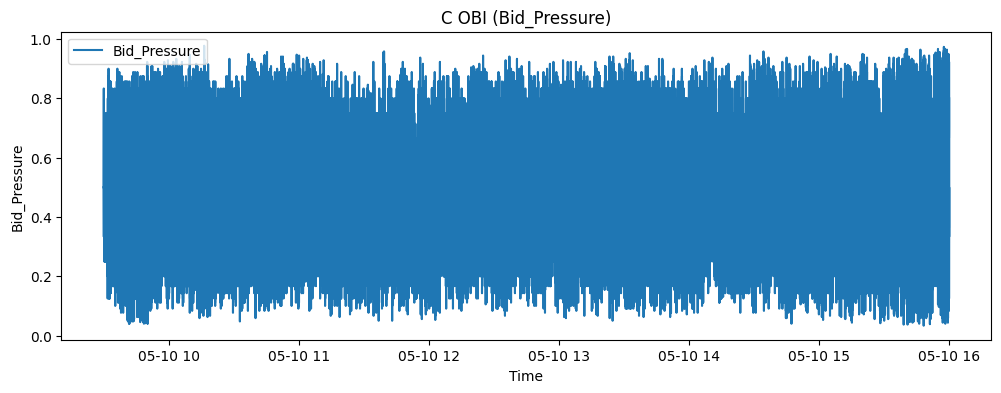

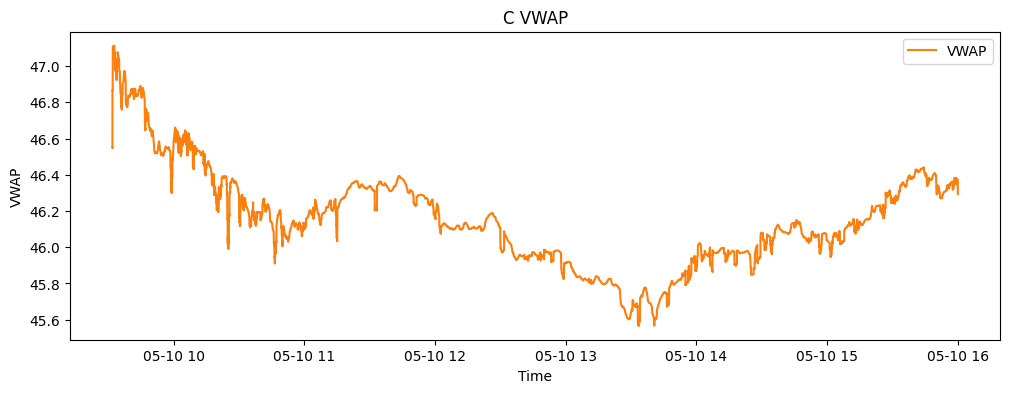

Processing OXY...

PERFORMANCE OXY STATISTICS:
Total returns: 43358.71%
Max drawdown: -0.00%
Average bid-ask spread: 0.081752

DAILY SHARPE RATIOS:
shape: (1, 2)
┌─────────────────────┬────────────────────┐
│ Timestamp           ┆ Daily_Sharpe_Ratio │
│ ---                 ┆ ---                │
│ datetime[ns]        ┆ f64                │
╞═════════════════════╪════════════════════╡
│ 2023-05-10 00:00:00 ┆ 0.797524           │
└─────────────────────┴────────────────────┘


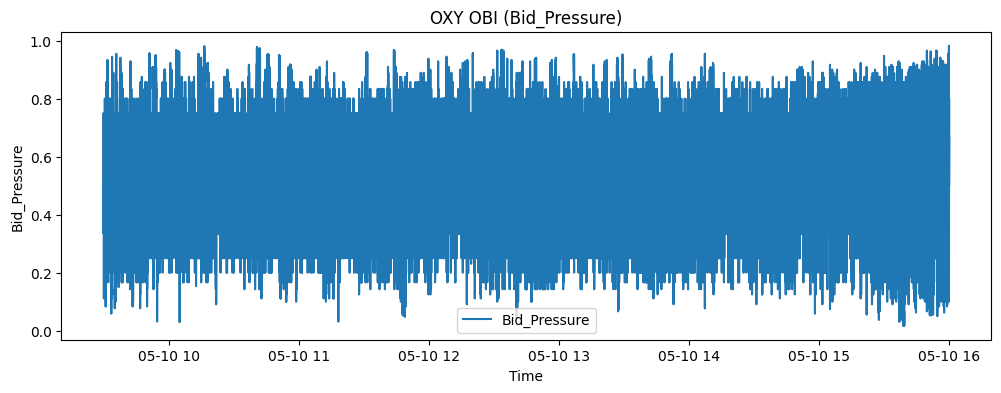

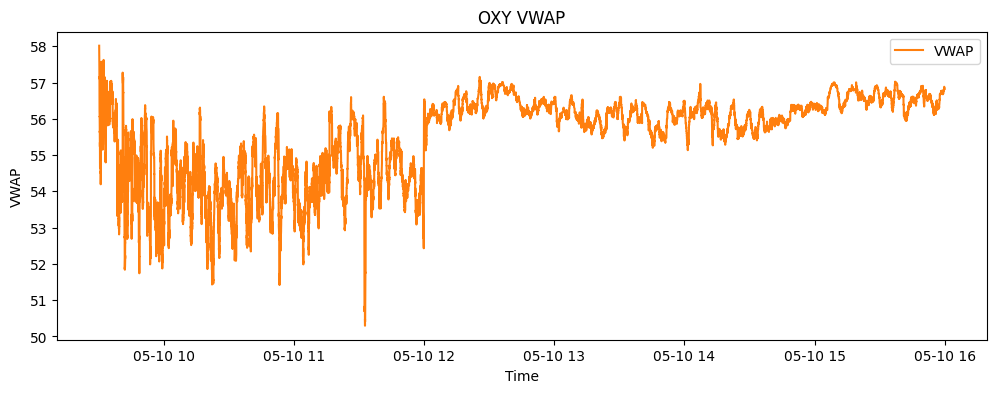

In [147]:
import pandas as pd

batch_results = []

stock_tickers = df["sym_root"].unique().to_list()
print("Tickers in data:", stock_tickers)

for ticker in stock_tickers:
    print(f"Processing {ticker}...")
    ticker_data = df.filter(pl.col("sym_root") == ticker)
    strategy = OBIVWAPStrategy(
        vwap_window=VWAP_WINDOW, 
        obi_threshold=OBI_THRESHOLD, 
        size_threshold=SIZE_THRESHOLD,
        vwap_threshold=VWAP_THRESHOLD,
        start_time=START_TIME, 
        end_time=END_TIME
    )
    ticker_data = strategy.generate_signals(ticker_data)
    backtest_data = strategy.backtest(ticker_data)
    metrics = evaluate_strategy_performance(backtest_data)
    batch_results.append({
        "ticker": ticker,
        "Total_Returns": metrics.get("Total_Returns"),
        "Average_Sharpe": metrics.get("Average_Sharpe"),
        "Average_Bid_Ask_Spread": metrics.get("Average_Bid_Ask_Spread"),
        "Cumulative_Trades": metrics.get("Cumulative_Trades"),
    })
    # --- Plot OBI (Bid_Pressure) ---
    plt.figure(figsize=(12, 4))
    plt.plot(ticker_data["Timestamp"], ticker_data["Bid_Pressure"], label="Bid_Pressure", color="tab:blue")
    plt.title(f"{ticker} OBI (Bid_Pressure)")
    plt.xlabel("Time")
    plt.ylabel("Bid_Pressure")
    plt.legend()
    plt.show()

    # --- Plot VWAP ---
    plt.figure(figsize=(12, 4))
    plt.plot(ticker_data["Timestamp"], ticker_data["VWAP"], label="VWAP", color="tab:orange")
    plt.title(f"{ticker} VWAP")
    plt.xlabel("Time")
    plt.ylabel("VWAP")
    plt.legend()
    plt.show()

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_94352/3374748477.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pd_data["Minute"] = pd_data["Timestamp"].dt.floor("T")


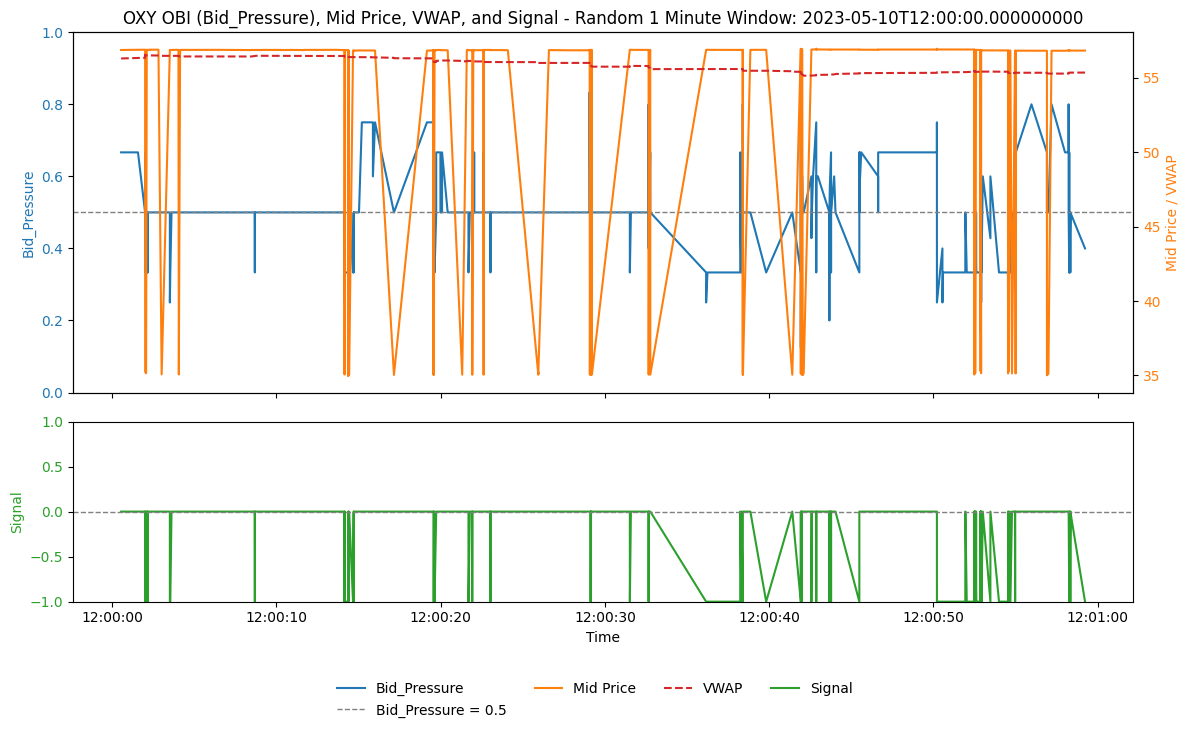

In [173]:
import numpy as np

# Convert to pandas DataFrame for resampling
pd_data = ticker_data.to_pandas()
pd_data["Timestamp"] = pd.to_datetime(pd_data["Timestamp"])

# Add a column for the minute
pd_data["Minute"] = pd_data["Timestamp"].dt.floor("T")

# Get all unique minutes
unique_minutes = pd_data["Minute"].unique()
if len(unique_minutes) > 0:
    # Pick a random minute
    random_minute = np.random.choice(unique_minutes)
    # Filter data for that minute
    minute_slice = pd_data[pd_data["Minute"] == random_minute]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # --- Top panel: Bid_Pressure (left), Mid Price and VWAP (right) ---
    color1 = "tab:blue"
    ax1.set_ylabel("Bid_Pressure", color=color1)
    ax1.plot(minute_slice["Timestamp"], minute_slice["Bid_Pressure"], label="Bid_Pressure", color=color1)
    ax1.tick_params(axis="y", labelcolor=color1)
    ax1.set_ylim(0, 1)
    ax1.axhline(0.5, color="gray", linestyle="--", linewidth=1, label="Bid_Pressure = 0.5")

    ax1b = ax1.twinx()
    color2 = "tab:orange"
    ax1b.set_ylabel("Mid Price / VWAP", color=color2)
    ax1b.plot(minute_slice["Timestamp"], minute_slice["MID_PRICE"], label="Mid Price", color=color2)
    color3 = "tab:red"
    ax1b.plot(minute_slice["Timestamp"], minute_slice["VWAP"], label="VWAP", color=color3, linestyle="--")
    ax1b.tick_params(axis="y", labelcolor=color2)

    # Collect legend handles and labels from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    all_lines = lines1 + lines2
    all_labels = labels1 + labels2

    ax1.set_title(f"{ticker} OBI (Bid_Pressure), Mid Price, VWAP, and Signal - Random 1 Minute Window: {random_minute}")

    # --- Bottom panel: Signal ---
    color4 = "tab:green"
    ax2.set_ylabel("Signal", color=color4)
    ax2.plot(minute_slice["Timestamp"], minute_slice["Signal"], label="Signal", color=color4)
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1, label="Signal = 0")
    ax2.set_ylim(-1, 1)
    ax2.tick_params(axis="y", labelcolor=color4)
    ax2.set_xlabel("Time")

    # Add all legends at the bottom outside the graph
    fig.legend(
        all_lines + [ax2.lines[0]], 
        all_labels + ["Signal"], 
        loc="lower center", 
        bbox_to_anchor=(0.5, -0.05), 
        ncol=4, 
        frameon=False
    )

    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()
else:
    print("No data available for random minute plot.")

In [143]:
pd_data.columns

Index(['date', 'time_m', 'time_m_nano', 'ex', 'sym_root', 'sym_suffix', 'bid',
       'bidsiz', 'ask', 'asksiz', 'qu_cond', 'qu_seqnum', 'natbbo_ind',
       'qu_cancel', 'qu_source', 'rpi', 'ssr', 'luld_bbo_indicator',
       'finra_bbo_ind', 'finra_adf_mpid', 'finra_adf_time',
       'finra_adf_time_nano', 'finra_adf_mpq_ind', 'finra_adf_mquo_ind',
       'sip_message_id', 'natl_bbo_luld', 'part_time', 'part_time_nano',
       'secstat_ind', 'Timestamp', 'MID_PRICE', 'Volume', 'VWAP',
       'Bid_Pressure', 'Signal', 'Minute'],
      dtype='object')

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

batch_results_mr = []

for ticker in stock_tickers:
    print(f"Processing {ticker} (Mean Reversion)...")
    ticker_data = df.filter(pl.col("sym_root") == ticker)
    strategy = MeanReversionStrategy(
        vwap_window=20,
        deviation_threshold=0.0001,
        volatility_window=20,
        volume_window=20,
        max_position=100,
        stop_loss_pct=0.3,
        profit_target_pct=0.6,
        risk_per_trade=0.02,
        min_profit_threshold=0.001,
        start_time=START_TIME,
        end_time=END_TIME
    )
    ticker_data = strategy.generate_signals(ticker_data)
    backtest_data = strategy.backtest(ticker_data)
    metrics = evaluate_strategy_performance(backtest_data)
    batch_results_mr.append({
        "ticker": ticker,
        "Total_Returns": metrics.get("Total_Returns"),
        "Average_Sharpe": metrics.get("Average_Sharpe"),
        "Average_Bid_Ask_Spread": metrics.get("Average_Bid_Ask_Spread"),
        "Cumulative_Trades": metrics.get("Cumulative_Trades"),
    })

    # --- Plot Signal and Mid Price for a random 1-minute window ---
    pd_data = backtest_data.to_pandas()
    pd_data["Timestamp"] = pd.to_datetime(pd_data["Timestamp"])
    pd_data["Minute"] = pd_data["Timestamp"].dt.floor("T")
    unique_minutes = pd_data["Minute"].unique()
    if len(unique_minutes) > 0:
        random_minute = np.random.choice(unique_minutes)
        minute_slice = pd_data[pd_data["Minute"] == random_minute]

        fig, ax1 = plt.subplots(figsize=(12, 4))
        color1 = "tab:green"
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Signal", color=color1)
        ax1.plot(minute_slice["Timestamp"], minute_slice["Signal"], label="Signal", color=color1)
        ax1.tick_params(axis="y", labelcolor=color1)
        ax1.axhline(0, color="gray", linestyle="--", linewidth=1, label="Signal = 0")

        ax2 = ax1.twinx()
        color2 = "tab:orange"
        ax2.set_ylabel("Mid Price", color=color2)
        ax2.plot(minute_slice["Timestamp"], minute_slice["MID_PRICE"], label="Mid Price", color=color2)
        ax2.tick_params(axis="y", labelcolor=color2)

        plt.title(f"{ticker} Mean Reversion Signal & Mid Price - Random 1 Minute Window: {random_minute}")
        fig.tight_layout()
        plt.show()
    else:
        print("No data available for random minute plot.")

# Optionally, display the results as a DataFrame
results_mr_df = pd.DataFrame(batch_results_mr)
print(results_mr_df)

Processing OXY (Mean Reversion)...


AttributeError: 'MeanReversionStrategy' object has no attribute 'cash'